In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
Features=pd.read_csv("../data/data_proccesed.csv")
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

Y -= 1

# encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

178

In [5]:
def custom_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.02)
scheduler = LearningRateScheduler(custom_scheduler)

normalizer = layers.Normalization()
normalizer.adapt(X)

k=5
model = models.Sequential([
    layers.Input(shape=(x_train.shape[1], 1)),
    normalizer,
    # layers.Reshape((89, 2)),
    layers.Conv1D(2**(k+4), 1, activation='relu'),
    layers.Conv1D(2**(k+3), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(2**(k+2), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(2**(k+1), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(2**(k), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [6]:
history=model.fit(x_train, y_train, epochs=80, batch_size=64, validation_data=(x_test, y_test),callbacks=scheduler)
model.save('../model')

Epoch 1/80
18/18 [==============================] - 4s 127ms/step - loss: 53349.8164 - accuracy: 0.1207 - val_loss: 8589.2783 - val_accuracy: 0.1215 - lr: 0.0010
Epoch 2/80
18/18 [==============================] - 2s 98ms/step - loss: 3693.0486 - accuracy: 0.1189 - val_loss: 13.3174 - val_accuracy: 0.1076 - lr: 0.0010
Epoch 3/80
18/18 [==============================] - 2s 100ms/step - loss: 8.1626 - accuracy: 0.1189 - val_loss: 2.6469 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 4/80
18/18 [==============================] - 2s 102ms/step - loss: 2.4161 - accuracy: 0.1840 - val_loss: 2.1433 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 5/80
18/18 [==============================] - 2s 101ms/step - loss: 2.1121 - accuracy: 0.2179 - val_loss: 1.9976 - val_accuracy: 0.2326 - lr: 0.0010
Epoch 6/80
18/18 [==============================] - 2s 103ms/step - loss: 2.0588 - accuracy: 0.2188 - val_loss: 1.8857 - val_accuracy: 0.2674 - lr: 0.0010
Epoch 7/80
18/18 [==============================] - 2s 104ms

INFO:tensorflow:Assets written to: ../model\assets


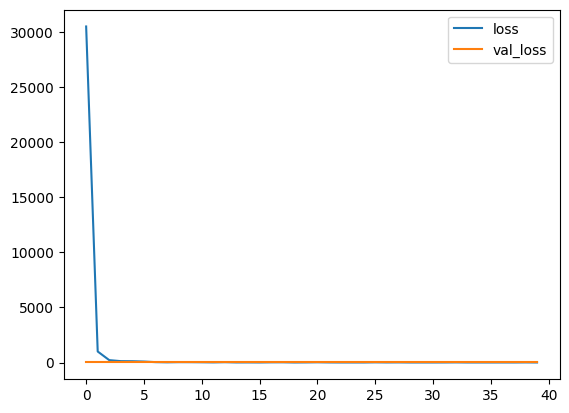

In [6]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

9/9 [==============================] - 0s 18ms/step
Test set accuracy: 35%


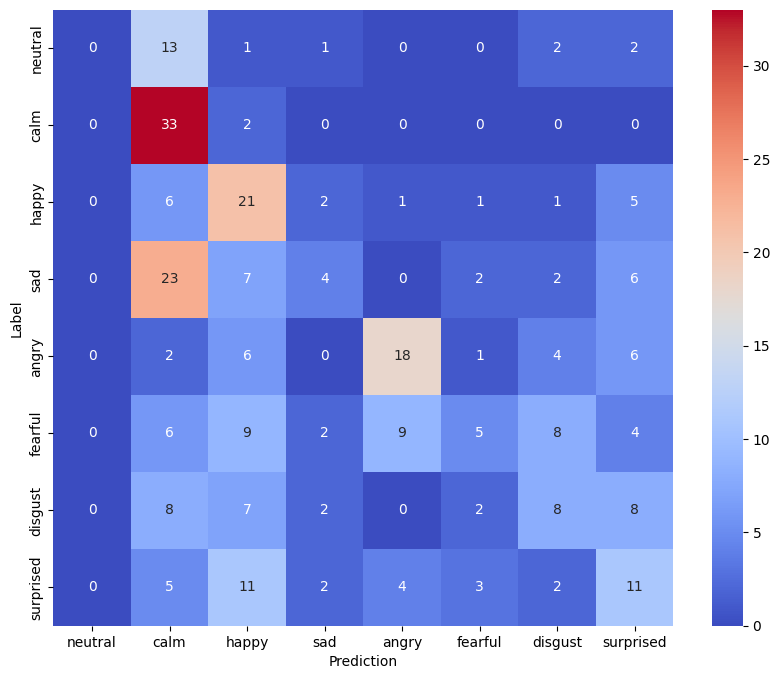

In [7]:
commands=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [8]:
model.evaluate(x_test,y_test)

9/9 [==============================] - 0s 17ms/step - loss: 1.7401 - accuracy: 0.3472


[1.7401235103607178, 0.3472222089767456]